In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.2.2
0.17.2


In [2]:
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

except:
    print("[INFO] Couldn't fing going_modular or helper_functions")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting data

In [4]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. FoodVision Mini model deployment experiment outline

## 3. Creating an EffNetB2 feature extractor

In [6]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same 
              out_features=3)) # change out_features to suit our number of classes

In [9]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [11]:
from torchinfo import summary

# summary(effnetb2,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [12]:
from going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [28]:
from going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
effnetb2.to(device)
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9848 | train_acc: 0.5667 | test_loss: 0.7388 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7138 | train_acc: 0.8375 | test_loss: 0.5851 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5871 | train_acc: 0.8938 | test_loss: 0.4897 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4480 | train_acc: 0.9104 | test_loss: 0.4342 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.4264 | train_acc: 0.9125 | test_loss: 0.3899 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4377 | train_acc: 0.8896 | test_loss: 0.3513 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4238 | train_acc: 0.8750 | test_loss: 0.3264 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3881 | train_acc: 0.8979 | test_loss: 0.3458 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3773 | train_acc: 0.8792 | test_loss: 0.3125 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3739 | train_acc: 0.8688 | test_loss: 0.2809 | test_acc: 0.9688


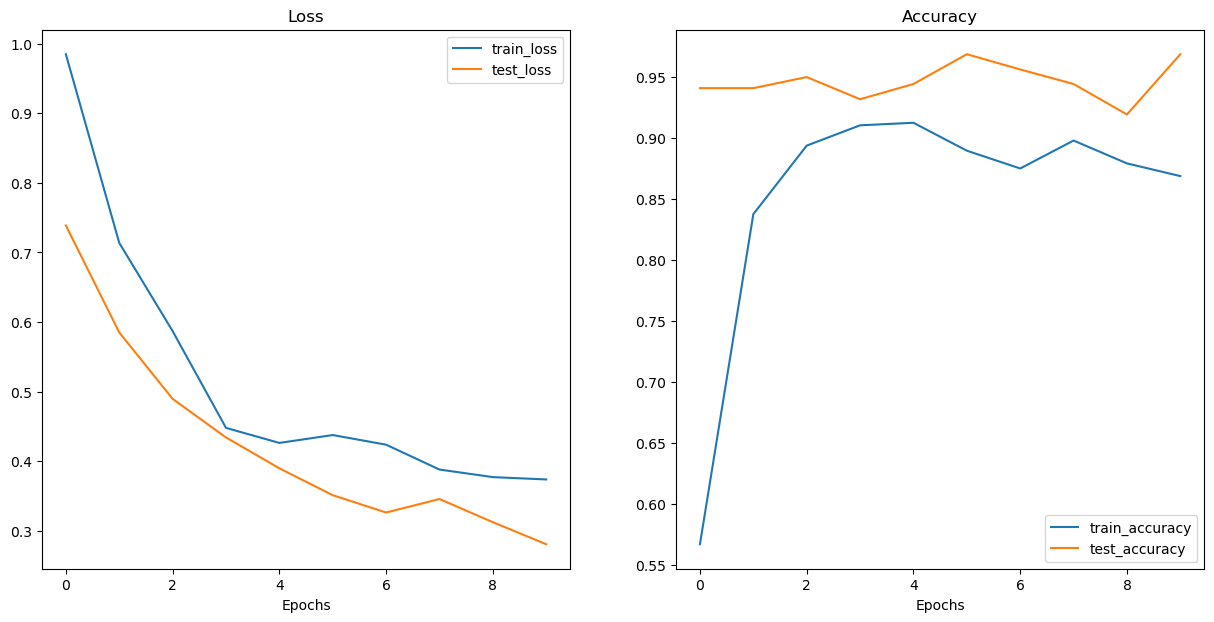

In [29]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [30]:
from going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [31]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
effnetb2_loaded_results = torch.load("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")
print(f"Pretrained EffNetb2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetb2 feature extractor model size: 29 MB


In [32]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [36]:
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28086442947387696,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [37]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [38]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                        out_features=num_classes))
    
    return model, transforms

In [39]:
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

In [40]:
from torchinfo import summary

# summary(vit,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [41]:
from going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [43]:
from going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
criterium = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit.to(device),
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=criterium,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


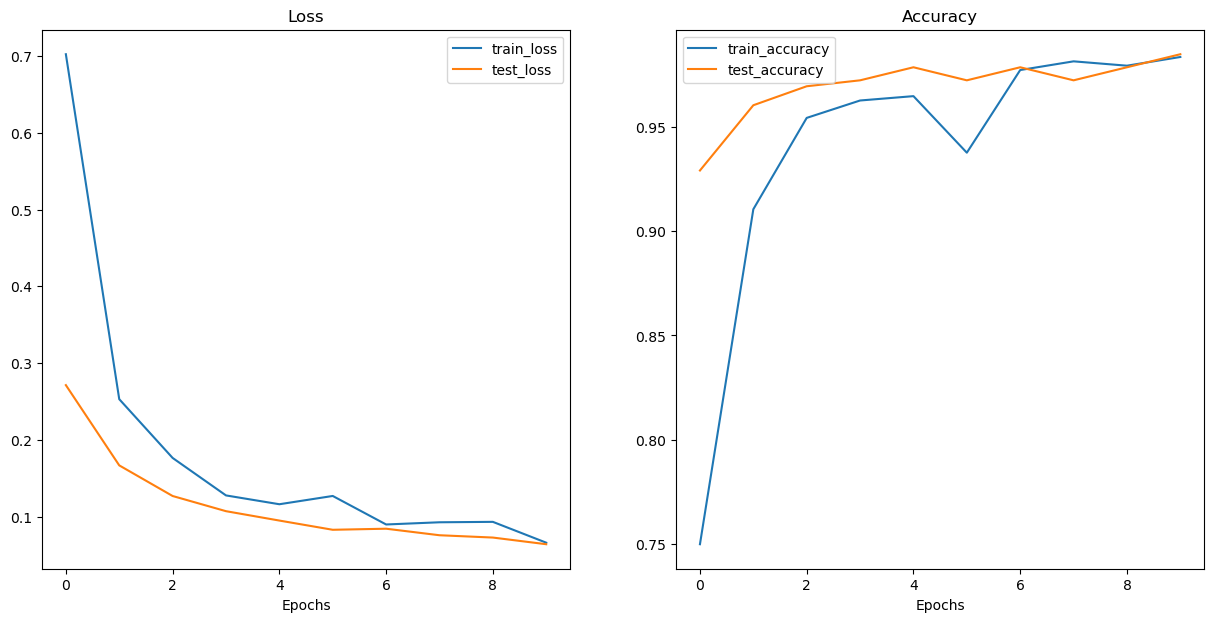

In [44]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [45]:
from going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [46]:
from pathlib import Path

pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained vit model size: {pretrained_vit_model_size} MB")

Pretrained vit model size: 327 MB


In [47]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [48]:
vit_stats = {"test_loss": vit_results["test_loss"][-1],
            "test_acc": vit_results["test_acc"][-1],
            "number_of_parameters": vit_total_params,
            "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.06418212177231908,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [49]:
from pathlib import Path

print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[-5:]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/833711.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/148765.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/771336.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2572488.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/416067.jpg')]

In [50]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    pred_list = []

    for path in tqdm(paths):
        pred_dict = {}

        pred_dict["image_path"] = str(path)
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()
        img = Image.open(path)
        transformed_image = transform(img).unsqueeze(0).to(device)

        model.to(device)
        model.eval()

        with torch.no_grad():
            pred_logit = model(transformed_image)  # inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        pred_dict["correct"] = class_name == pred_class
        pred_list.append(pred_dict)

    return pred_list

In [51]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [52]:
effnetb2_test_pred_dicts[:5]

[{'image_path': 'data/pizza_steak_sushi_20_percent/test/sushi/705150.jpg',
  'class_name': 'sushi',
  'pred_prob': 0.5944,
  'pred_class': 'sushi',
  'time_for_pred': 0.2019,
  'correct': True},
 {'image_path': 'data/pizza_steak_sushi_20_percent/test/sushi/2743100.jpg',
  'class_name': 'sushi',
  'pred_prob': 0.9198,
  'pred_class': 'sushi',
  'time_for_pred': 0.0976,
  'correct': True},
 {'image_path': 'data/pizza_steak_sushi_20_percent/test/sushi/1994748.jpg',
  'class_name': 'sushi',
  'pred_prob': 0.5362,
  'pred_class': 'sushi',
  'time_for_pred': 0.0827,
  'correct': True},
 {'image_path': 'data/pizza_steak_sushi_20_percent/test/sushi/124279.jpg',
  'class_name': 'sushi',
  'pred_prob': 0.5619,
  'pred_class': 'sushi',
  'time_for_pred': 0.0996,
  'correct': True},
 {'image_path': 'data/pizza_steak_sushi_20_percent/test/sushi/1346344.jpg',
  'class_name': 'sushi',
  'pred_prob': 0.9557,
  'pred_class': 'sushi',
  'time_for_pred': 0.0935,
  'correct': True}]

In [53]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/7...,sushi,0.5944,sushi,0.2019,True
1,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9198,sushi,0.0976,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.5362,sushi,0.0827,True
3,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.5619,sushi,0.0996,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9557,sushi,0.0935,True


In [54]:
effnetb2_test_pred_df.correct.value_counts()

correct
True     145
False      5
Name: count, dtype: int64

In [55]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffnetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffnetB2 average time per prediction: 0.0893 seconds


In [56]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28086442947387696,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.0893}

In [57]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [58]:
vit_test_pred_dicts[:2]

[{'image_path': 'data/pizza_steak_sushi_20_percent/test/sushi/705150.jpg',
  'class_name': 'sushi',
  'pred_prob': 0.9447,
  'pred_class': 'sushi',
  'time_for_pred': 0.3988,
  'correct': True},
 {'image_path': 'data/pizza_steak_sushi_20_percent/test/sushi/2743100.jpg',
  'class_name': 'sushi',
  'pred_prob': 0.9962,
  'pred_class': 'sushi',
  'time_for_pred': 0.171,
  'correct': True}]

In [59]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/7...,sushi,0.9447,sushi,0.3988,True
1,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9962,sushi,0.1710,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9630,sushi,0.2314,True
3,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8947,sushi,0.2673,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9957,sushi,0.2667,True


In [60]:
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [61]:
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"Average time per pred ViT: {vit_average_time_per_pred} seconds")

Average time per pred ViT: 0.2043 seconds


In [62]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06418212177231908,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.2043}

In [63]:
df = pd.DataFrame([effnetb2_stats, vit_stats])
df["model"] = ["EffnetB2", "ViT"]
df["test_acc"] = round(df["test_acc"] * 100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.280864,96.88,7705221,29,0.0893,EffnetB2
1,0.064182,98.47,85800963,327,0.2043,ViT


In [64]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffnetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.228516,1.016412,11.135432,11.275862,2.287794


In [65]:
import os

os.makedirs("images", exist_ok=True)

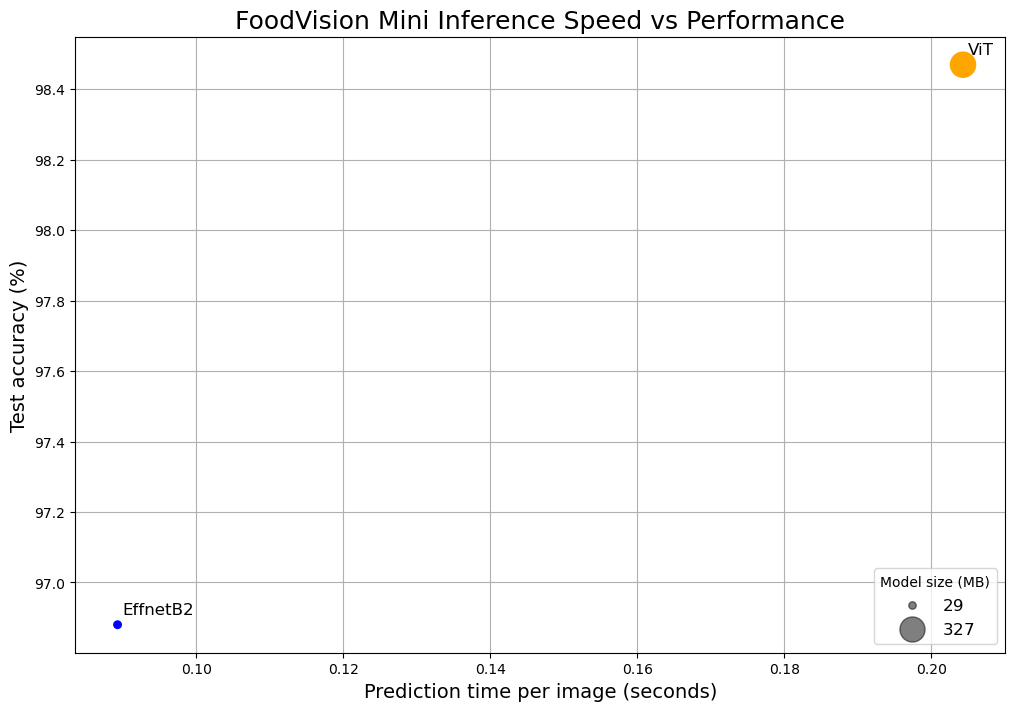

In [66]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], 
                     s=df["model_size (MB)"])  # Use model sizes as dot sizes
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),  
                fontsize=12)  

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")
plt.show()


In [67]:
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr
print(f"Gradio version: {gr.__version__}")

Gradio version: 4.26.0


In [68]:
effnetb2.to("cuda")

next(iter(effnetb2.parameters())).device

device(type='cuda', index=0)

In [69]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and return prediction and time taken"""
    start_time = timer()
    img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time